In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.utils  import shuffle
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
train_dat = pd.read_csv("../input/trainLabels.csv")
train_dat.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [4]:
listing = os.listdir("../input") 
listing.remove("trainLabels.csv")
np.size(listing)

1000

In [5]:
img_rows , img_colms = 200, 200
imgMatrix = []
imgLabels = []

for file in listing:
    base = os.path.basename("../input/" + file)
    fileName = os.path.splitext(base)[0]
    imgLabels.append(train_dat.loc[train_dat.image==fileName, 'level'].values[0])
    im = Image.open("../input/" + file)   
    img = im.resize((img_rows,img_colms))
    gray = img.convert('L')
    imgMatrix.append(np.array(gray).flatten())

In [6]:
imgMatrix = np.asarray(imgMatrix)
imgLabels = np.asarray(imgLabels)

data, label = shuffle(imgMatrix,imgLabels, random_state=2)
train_data = [data,label]
type(train_data)

list

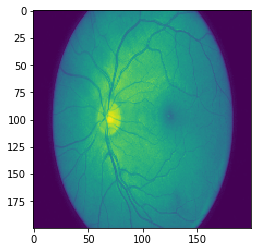

In [7]:
img=imgMatrix[167].reshape(img_rows,img_colms)
plt.imshow(img)
plt.imshow(img)

In [8]:
(X,y) = (train_data[0], train_data[1])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)
print(X_train.shape)
print(X_test.shape)

(750, 40000)
(250, 40000)


In [9]:
X_train = X_train.reshape(X_train.shape[0], img_colms, img_rows, 1)
X_test = X_test.reshape(X_test.shape[0], img_colms, img_rows, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 200
X_test /= 200

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (750, 200, 200, 1)
750 train samples
250 test samples


In [10]:
nb_classes = 5
batch_size = 36
no_epoch = 8



nb_filters = 36  #convolution filters
nb_pool = 2
nb_conv = 3 #Kernals

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

In [15]:
#Neural Network
model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv,
                        border_mode='valid',
                        input_shape=(img_colms, img_rows, 1)))
convout1 = Activation('relu')
model.add(convout1)
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
convout2 = Activation('relu')
model.add(convout2)
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (3, 3), input_shape=(200, 200,..., padding="valid")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (3, 3))`
  if __name__ == '__main__':


In [16]:
validation_data_generator = ImageDataGenerator()
train_data_generator = ImageDataGenerator(width_shift_range=0.2,height_shift_range=0.2,rotation_range=20,zoom_range=0.2 )

batchsize=8
train_generator=train_data_generator.flow(X_train, Y_train, batch_size=batchsize) 
validation_generator=validation_data_generator.flow(X_test, Y_test,batch_size=batchsize)

In [19]:
model.fit_generator(train_generator, steps_per_epoch=int(len(X_train)/batchsize), epochs=3, validation_data=validation_generator, validation_steps=int(len(X_test)/batchsize))

Epoch 1/3
93/93 [==============================] - 184s 2s/step - loss: 1.1322 - val_loss: 0.9336
Epoch 2/3
93/93 [==============================] - 183s 2s/step - loss: 0.9806 - val_loss: 0.9872
Epoch 3/3
93/93 [==============================] - 180s 2s/step - loss: 0.9782 - val_loss: 0.9164


In [20]:
score = model.evaluate(X_test, Y_test, verbose = 0)
print(score)

0.9108913497924804
